In [1]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   f"/content/drive/MyDrive/CVProjectDataNew",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"/content/drive/MyDrive/CVProjectDataNew",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1818 files belonging to 2 classes.
Using 1455 files for training.
Found 1818 files belonging to 2 classes.
Using 363 files for validation.


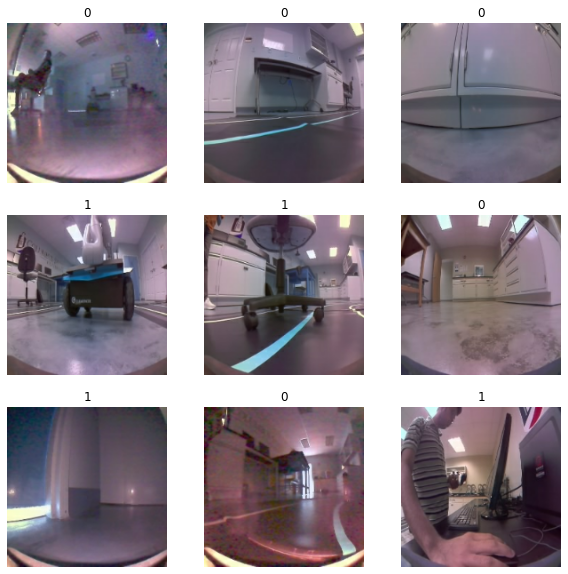

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
    ]
)

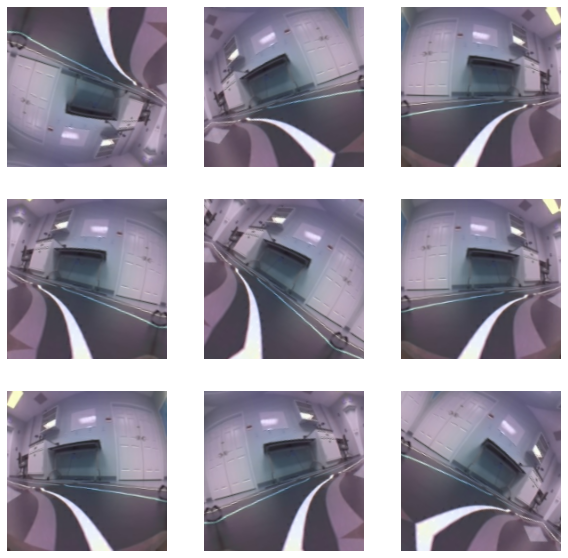

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [9]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_ds = train_ds.prefetch(buffer_size=4)
val_ds = val_ds.prefetch(buffer_size=4)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
      activation = "softmax"
      units = num_classes

    x = layers.Dropout(0.5)(x)
    print(units)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

1


In [ ]:
# model.load_weights("/content/drive/MyDrive/car_view/state1.h5")

In [12]:
epochs = 30

callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CVProjectDataNew/car_view.h5", save_best_only=True, verbose=1)]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=["accuracy"],
)
history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,verbose=1)

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.7753
Epoch 1: val_loss improved from inf to 0.70802, saving model to /content/drive/MyDrive/CVProjectDataNew/car_view.h5
46/46 [==============================] - 102s 2s/step - loss: 0.4973 - accuracy: 0.7753 - val_loss: 0.7080 - val_accuracy: 0.4848
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8192
Epoch 2: val_loss did not improve from 0.70802
46/46 [==============================] - 24s 504ms/step - loss: 0.3945 - accuracy: 0.8192 - val_loss: 0.7415 - val_accuracy: 0.4848
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8447
Epoch 3: val_loss did not improve from 0.70802
46/46 [==============================] - 24s 508ms/step - loss: 0.3718 - accuracy: 0.8447 - val_loss: 0.8211 - val_accuracy: 0.4848
Epoch 4/30
46/46 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8708
Epoch 4: val_loss di

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling_1[0][0]']        

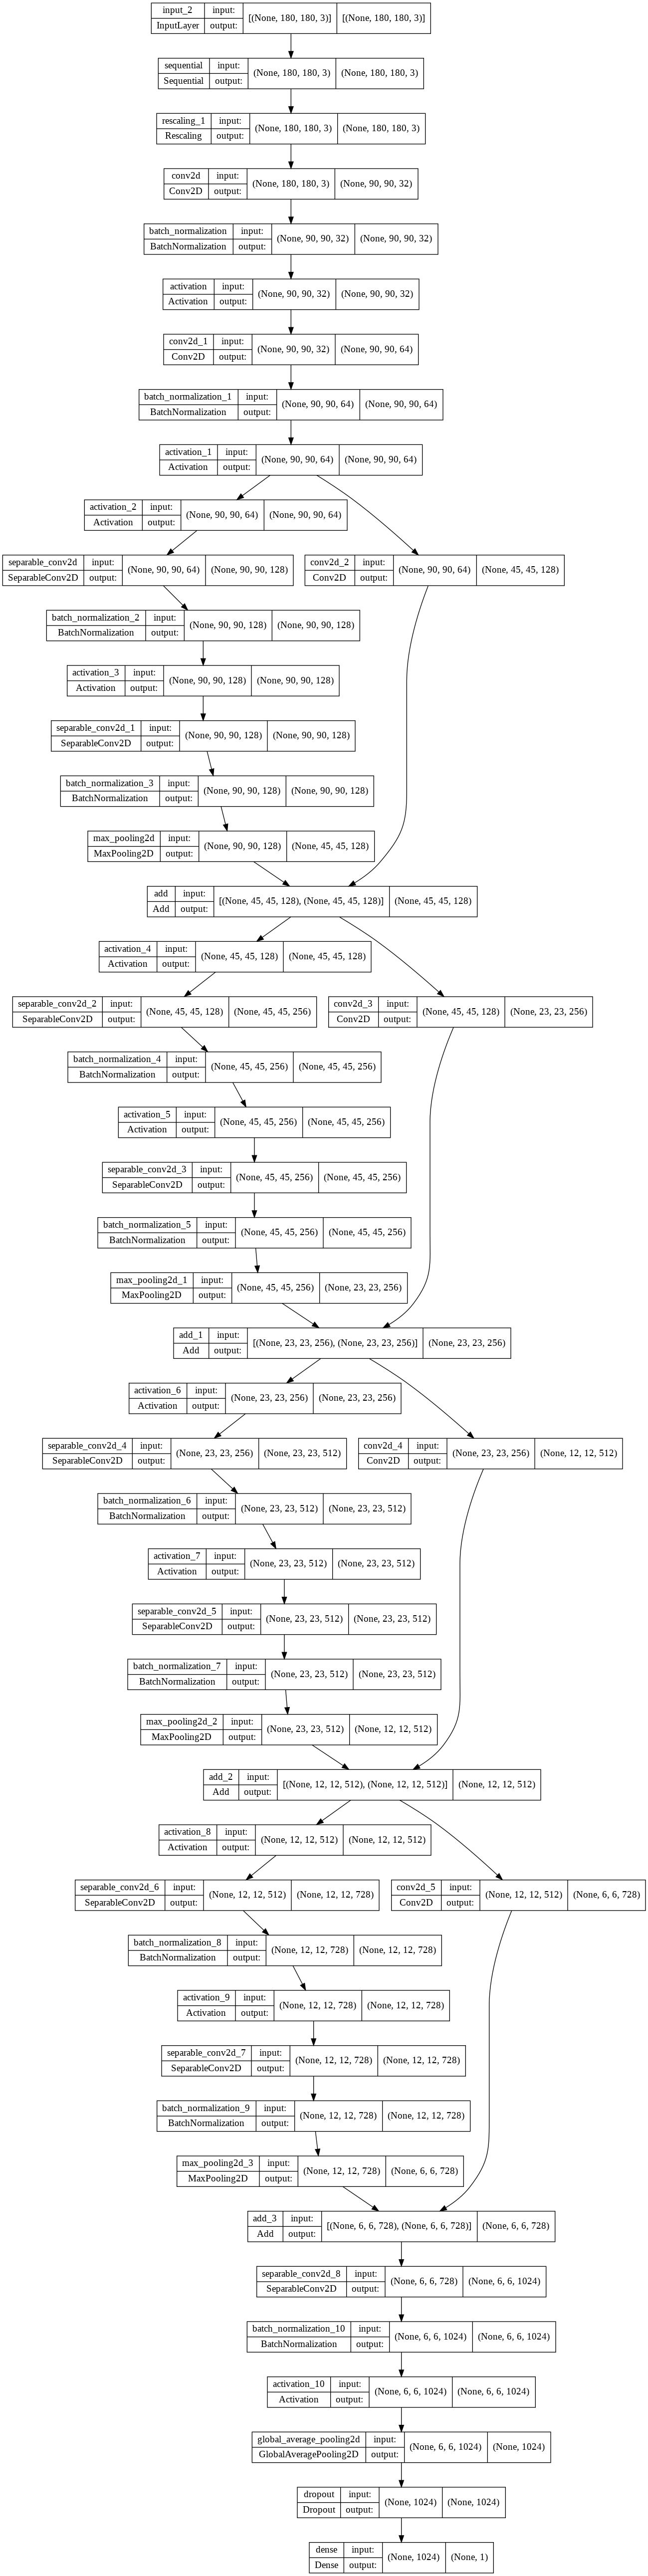

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 



# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/CVProjectDataNew/history_custom.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


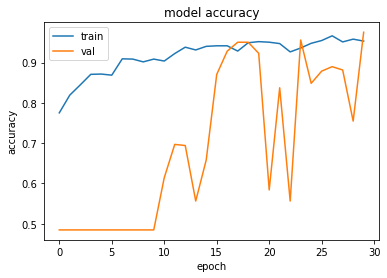

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
#/content/weights
from tensorflow.keras.models import load_model
model2 = load_model("/content/drive/MyDrive/CVProjectDataNew/car_view.h5")

In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model2) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/CVProjectDataNew/model.tflite', 'wb') as f:
  f.write(tflite_model)